In [1]:
import os
import sys
sys.path.append("../")

import tensorflow as tf
from glob import glob
from typing import List
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from typing import Dict, List, Union
from rosbag2numpy import config as params
from rosbag2numpy.data_processing.data_loader_fv import dataset_loader
import time
from tqdm import trange,tqdm
from rosbag2numpy import SEED
from typing import List
print(tf.__version__)
tf.random.set_seed(SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

2.3.0


## Load data set

In [2]:
ds_loader = dataset_loader(
    tfrec_dir= '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal',
    #'/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal',#params.get("data_dir"),
    batch_size=32,
    shuffle_buffer=3200,
    normalize_coords=True,
    normalize_factor=1536.0
)
ds_train, ds_valid, ds_test, ds_test_all = ds_loader.build_scenario_dataset(no_train_scene=8,no_valid_scene=1,no_test_scene=1)

Scenarios:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario1', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario2', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario3', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario4', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario5', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario_ph_11', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario_ph_12', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario_ph_13', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario_ph_14', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal/scenario_ph_15']
Test scenario:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_r

## Numpy data for test set and visual inspection

In [3]:
def _get_test_ds_size(ds_test) -> int:
    """get the size of test dataset

    Args:
        ds_test (tf.data.Dataset): [description]

    Returns:
        [int]: [Number of Samples inside dataset]
    """
    num_of_samples = 0
    # Looping through all batches in test dataset
    for input_batch, output_batch in ds_test:
        # Looping through all samples for a single (current) batch
        #print(input_batch[0].numpy().shape)
        for _ in range(0, len(input_batch[0].numpy())):
            num_of_samples += 1
    return num_of_samples

def get_np_test_ds(ds_test) -> Dict[str, Union[ndarray, List]]:
    """Test dataset (in tf.data.Dataset build) to numpy arrays

    Args:
        ds_test ([type]): tf.data.Dataset

    Returns:
        Dict[str,Union[ndarray,List]]: dictionary of feature_vector,costmap,init_path,opt_path,car_odo,file_details,unequal_indices, diff_path
    """
    samples = _get_test_ds_size(ds_test)
    np_tst_feature_vector = np.zeros(shape=(samples,25,1040))
    np_tst_costmap = np.zeros(shape=(samples, 1536, 1536)).astype(np.float16)
    
    #np_tst_left_bnd = np.zeros(shape=(samples, 25, 2))
    #np_tst_right_bnd = np.zeros(shape=(samples, 25, 2))
    np_tst_car_odo = np.zeros(shape=(samples, 2))
    np_tst_init_path = np.zeros(shape=(samples, 25, 2))
    np_tst_opt_path = np.zeros(shape=(samples, 25, 2))
    list_tst_file_details = []

    #list_unequal_indices = []

    #output
    np_tst_diff_path = np.zeros(shape=(samples, 25, 2))

    j = 0
    for input_batch, output_batch in ds_test:

        for i in range(len(input_batch[0].numpy())):
            np_tst_feature_vector[j] = input_batch[0][i].numpy()
            np_tst_costmap[j] = input_batch[1][i].numpy().astype(np.float16)
            #np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            #np_tst_left_bnd[j] = input_batch[2][i].numpy()
            #np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_init_path[j] = input_batch[2][i].numpy()
            np_tst_opt_path[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            list_tst_file_details.append(input_batch[5][i])
            #list_unequal_indices.append(input_batch[6][i])

            #np_tst_opt_path[j] = output_batch[i].numpy()
            np_tst_diff_path[j] = output_batch[i].numpy()
            j = j + 1

    np_ds_test = {
        "feature_vector": np_tst_feature_vector,
        "cost_map": np_tst_costmap,
        #"grid_org_res": np_tst_grid_org_res,
        #"left_bnd": np_tst_left_bnd,
        #"right_bnd": np_tst_right_bnd,
        "init_path": np_tst_init_path,
        "opt_path": np_tst_opt_path,
        "car_odo": np_tst_car_odo,
        "file_details": list_tst_file_details,
        #"unequal_indices": list_unequal_indices,
        "diff_path": np_tst_diff_path,

    }

    # np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path
    return np_ds_test

np_test_ds_all = get_np_test_ds(ds_test=ds_test_all)

cost_map = np_test_ds_all["cost_map"]
feature_v = np_test_ds_all["feature_vector"]
init_path = np_test_ds_all["init_path"]
opt_path = np_test_ds_all["opt_path"]
car_odo = np_test_ds_all["car_odo"]
file_details = np_test_ds_all["file_details"]
diff_path = np_test_ds_all["diff_path"]

## Load pretrained model

In [4]:

wandbmodel_path = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210924_031631-lhsjbn8r/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20211007_142205-4f16v6pz/files/model-best.h5' (GRU-daily-star-19)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_142250-349jb33u/files/model-best.h5' (TDD-4 units - youthful-monkey-60)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_083501-7b6nj1fr/files/model-best.h5' (breezy-sweep-15)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_080546-xoxoxow6/files/model-best.h5' (prime-sweep-5)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210924_031631-lhsjbn8r/files/model-best.h5' (laced-sweep-28)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_162541-2bwn3ku4/files/model-best.h5'  (iconic-silence- , hybrid (2,2))
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210922_010110-1sb0es02/files/model-best.h5' (quiet-meadow-14, LSTM (25,50))
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_225739-3tq5o6wv/files/model-best.h5' (noble-ebergy-9,bidiLSTM)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_223929-2789gz0e/files/model-best.h5' (dark-energy-TDD-64)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_154305-30js7pw0/files/model-best.h5' (divine-snow-LSTM(2,50))

all_model_paths = ['/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_083501-7b6nj1fr/files/model-best.h5' , 
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_080546-xoxoxow6/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210924_031631-lhsjbn8r/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_162541-2bwn3ku4/files/model-best.h5'  ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210922_010110-1sb0es02/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_225739-3tq5o6wv/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_142250-349jb33u/files/model-best.h5',
'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_223929-2789gz0e/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_154305-30js7pw0/files/model-best.h5' ]

#all_model_paths = ['/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20211007_142205-4f16v6pz/files/model-best.h5']

load_wandb  = tf.keras.models.load_model(wandbmodel_path)
predictions = load_wandb.predict(feature_v)
predicted_paths = init_path - predictions
predicted_paths.shape
np.shape(np.expand_dims(feature_v[0],axis=0))

print(len(all_model_paths))
load_wandb.summary()

9
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 1040)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 25, 2)             8344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                10600     
_________________________________________________________________
reshape (Reshape)            (None, 25, 2)             0         
Total params: 18,944
Trainable params: 18,944
Non-trainable params: 0
_________________________________________________________________


In [5]:
wandbmodel_path.split(os.path.sep)[-3]

'run-20210924_031631-lhsjbn8r'

In [6]:
f'{wandbmodel_path.split("_")[-1].split(".")[0]}.mat'

'031631-lhsjbn8r/files/model-best.mat'

## Save .mat for all data including predicted optimized paths

In [13]:
import scipy.io
"""np.savez(

    wandbmodel_path.split("_")[-1].split(".")[0],
    costmap : cost_map,
    init_path : init_path,
    opt_path : opt_path,
    diff_path : diff_path,
    car_odo : car_odo, 
    feature_vector : feature_v,
    file_details:file_details, 
    pred_path : predicted_paths

    )"""


for modelpath in all_model_paths:
    load_wandb  = tf.keras.models.load_model(modelpath)
    predictions = load_wandb.predict(feature_v)
    predicted_paths = init_path - predictions

    data_np ={
        'costmap' : cost_map,
        'init_path' : init_path,
        'opt_path' : opt_path,
        'diff_path' : diff_path,
        'car_odo' : car_odo, 
        'feature_vector' : feature_v,
        'file_details':file_details, 
        'pred_path' : predicted_paths
    }
#Saving to mat file
    mat_root_path = '/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles'
    filename = os.path.join(mat_root_path,f'{modelpath.split(os.path.sep)[-3]}.mat')
    #f'{wandbmodel_path.split("_")[-1].split(".")[0]}.mat'
    print(filename)
    scipy.io.savemat(file_name=filename,mdict=data_np)

/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210925_083501-7b6nj1fr.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210925_080546-xoxoxow6.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210924_031631-lhsjbn8r.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210922_162541-2bwn3ku4.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210922_010110-1sb0es02.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210921_225739-3tq5o6wv.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210922_142250-349jb33u.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210921_223929-2789gz0e.mat
/projects/malyala/New_folder/rosbag2numpy/test_results/matfiles/run-20210922_154305-30js7pw0.mat


## profile predict function 

In [89]:
def profile_predict():
    load_wandb.predict(feature_v)

%load_ext line_profiler

%lprun -f profile_predict profile_predict()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 0.163236 s
File: <ipython-input-89-bb3b8e5812e9>
Function: profile_predict at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def profile_predict():
     2         1     163236.0 163236.0    100.0      load_wandb.predict(feature_v)

## Saving keras model

In [5]:
# Saving keras models
#step 1
# serialize model to json(no weights, only structure)
"""
with open('best_model.json','w') as f:
    f.write(pp_model.to_json())
"""
#step 2
"""
pp_model.save_weights('best_keras_weights.h5')
"""

#step 3
# Load serialized model from json(contains no weights only structue)

"""json_file = open('best_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
pp_model = tf.keras.models.model_from_json(loaded_model_json,custom_objects={'CustomMaskLayer':endpoint_in_model.CustomMaskLayer})
"""
#step4
# load weights into model created from json

"""pp_model.load_weights('/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/keras_weights.h5')
"""

"""
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
pp_model.compile(
        optimizer=opt, 
        loss=[euclidean_distance_loss,endpoint_loss],
        loss_weights=params.get("loss_weights"), metrics=params.get("metric")
    )#pp_model.summary()
test_loss,test_accuracy = pp_model.evaluate(ds_test)
"""

'\nopt = tf.keras.optimizers.Adam(learning_rate=0.02)\npp_model.compile(\n        optimizer=opt, \n        loss=[euclidean_distance_loss,endpoint_loss],\n        loss_weights=params.get("loss_weights"), metrics=params.get("metric")\n    )#pp_model.summary()\ntest_loss,test_accuracy = pp_model.evaluate(ds_test)\n'

## Plotting individual sample

tf.Tensor(b'scenario_ph_15/2021-07-22_16-12-14/2021-07-22_16-12-15_0_nos156bgm_fv_paths_odo_unequal.npz', shape=(), dtype=string)


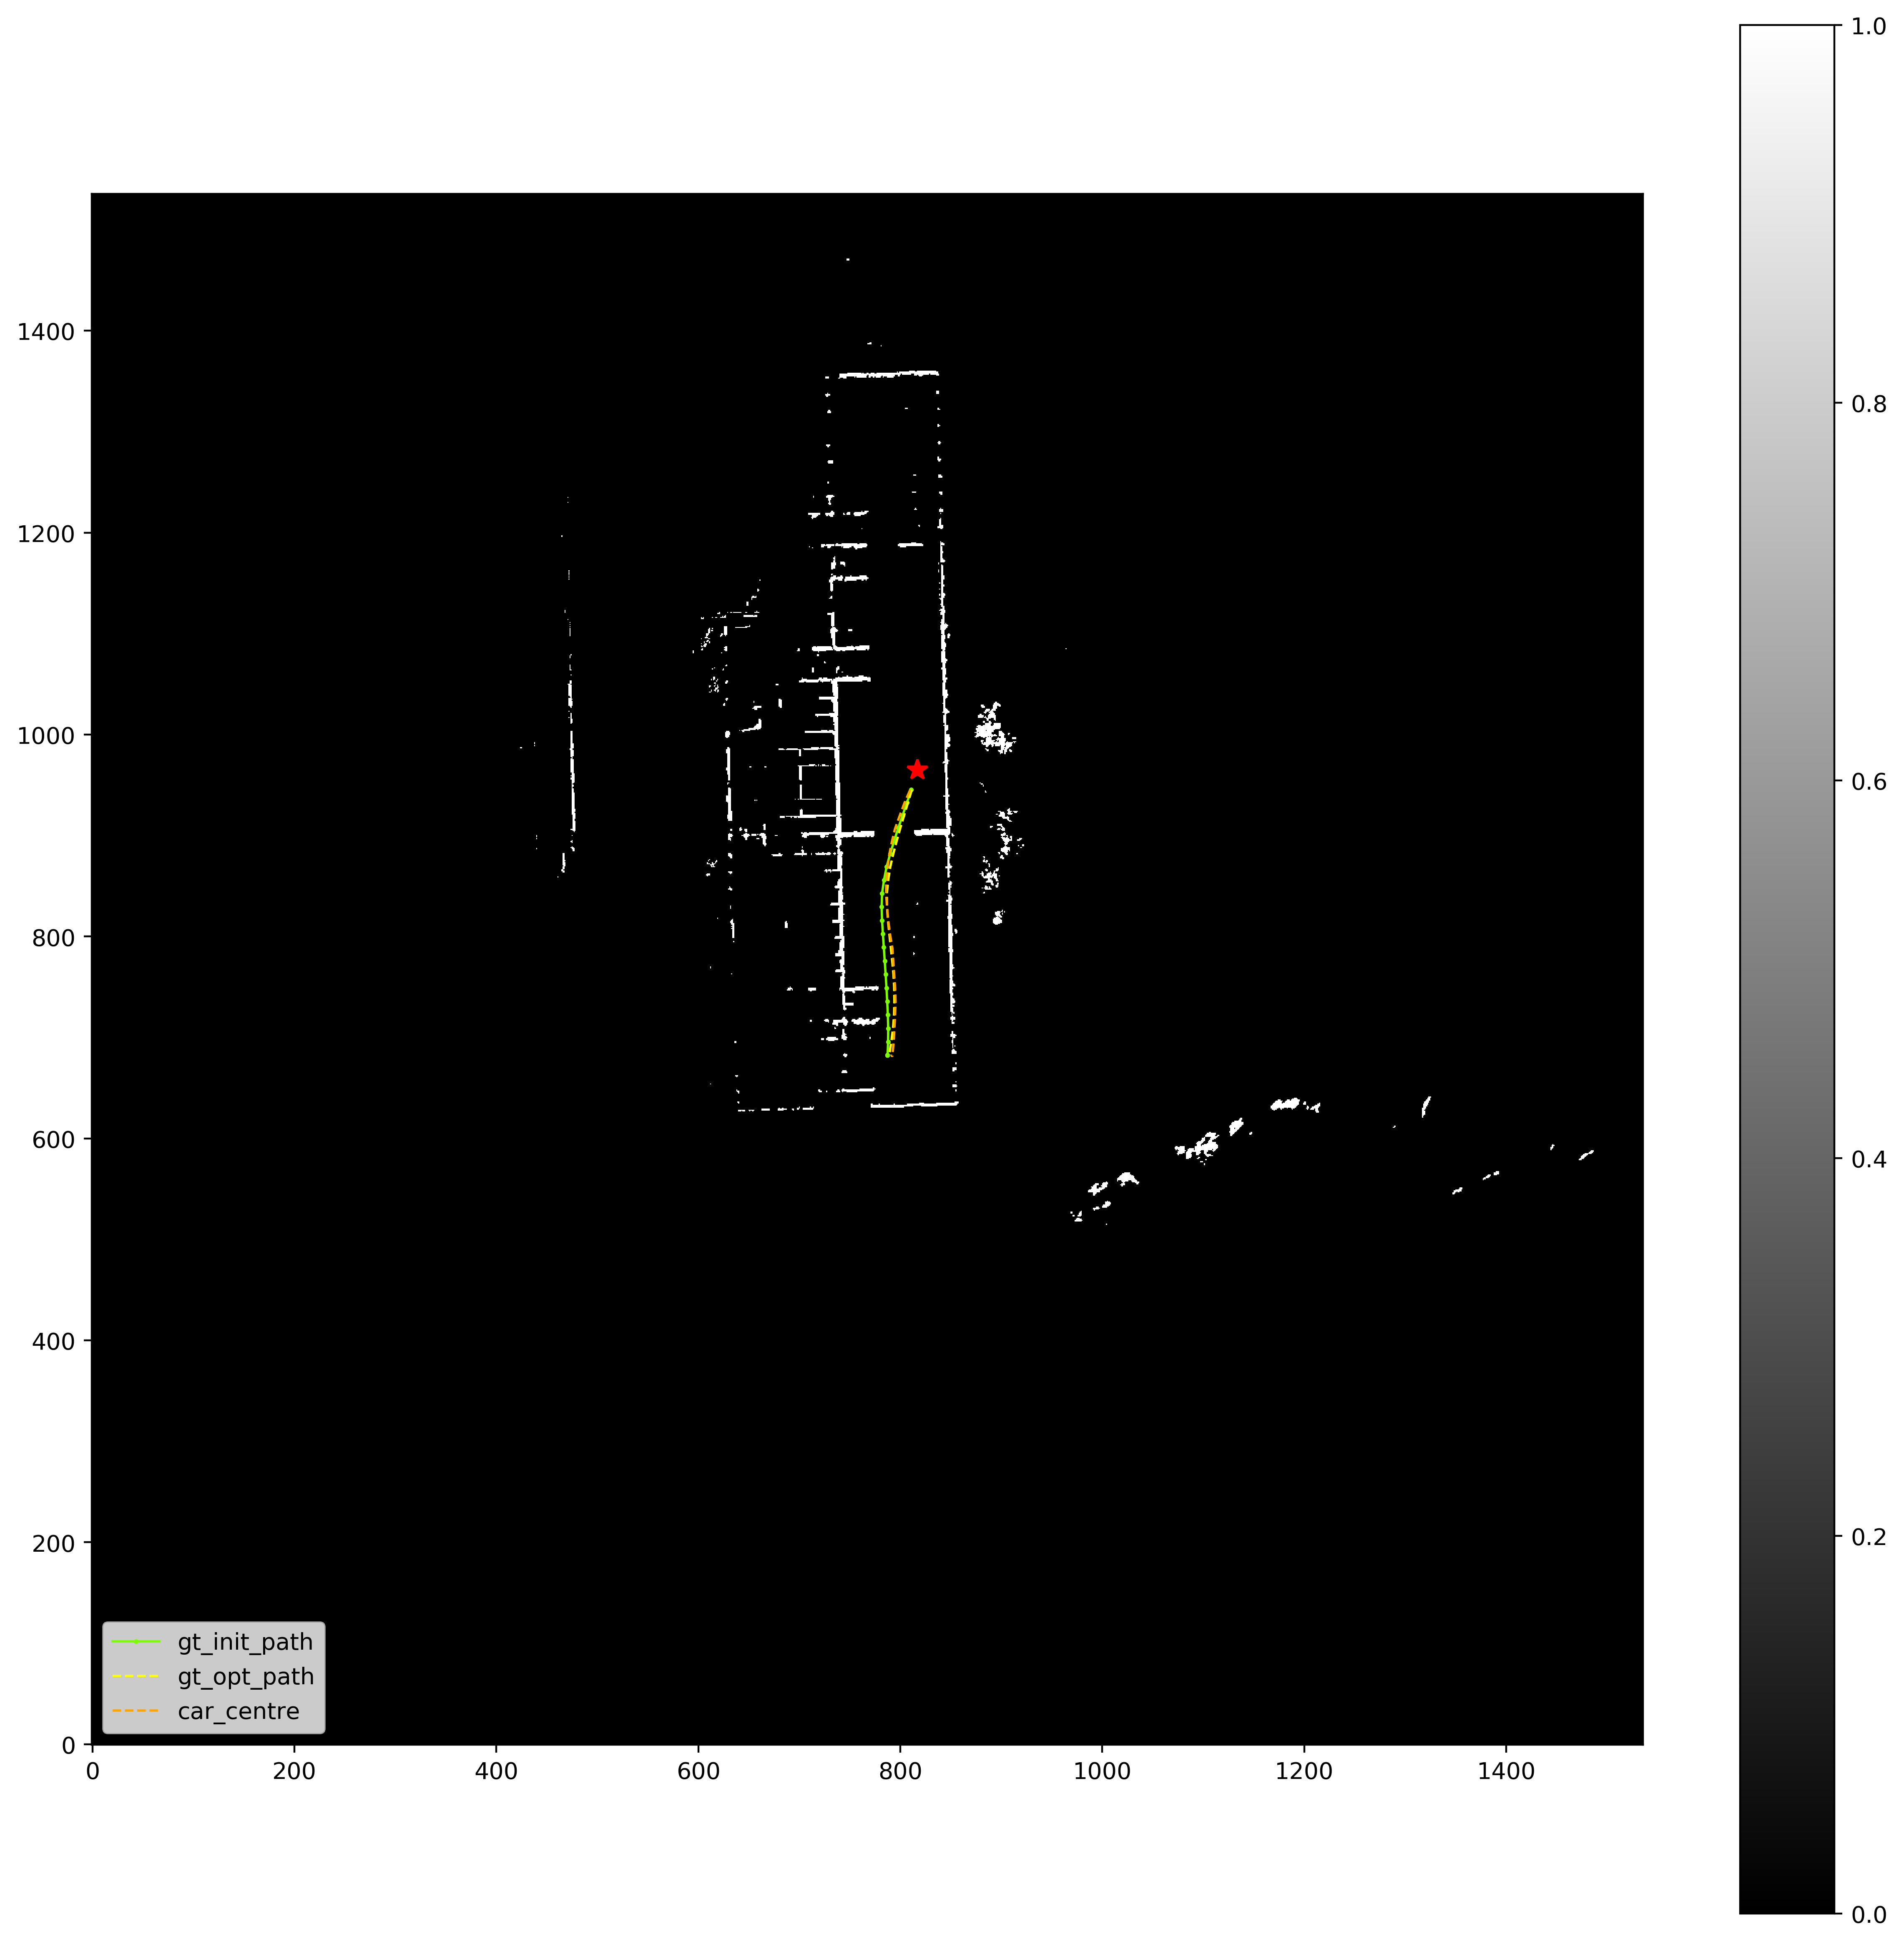

In [6]:
idx=107
normalized_factor=1536

b_feature_v = np.zeros_like(feature_v[idx])
b_feature_v[np.where(feature_v[idx]>0)]=1
b_predictions = load_wandb.predict(np.expand_dims(b_feature_v,axis=0))
b_predicted_paths = init_path - b_predictions

bgm = np.zeros_like(cost_map[idx])
bgm[np.where(cost_map[idx].astype(float)>0)]=1
plt.figure(figsize=(15,15),dpi=400)
plt.imshow(bgm.astype(float),origin='lower',cmap='gray')
plt.colorbar()
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)


plt.plot(
    b_predicted_paths[idx][:, 0]*normalized_factor,
    b_predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)

plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "*",
    color="red",
    markersize=9,
)
plt.legend(['gt_init_path', 'gt_opt_path', 'car_centre'], loc='lower left')
print(file_details[idx])

Text(796.4791564941406, 740.7411651611328, '')

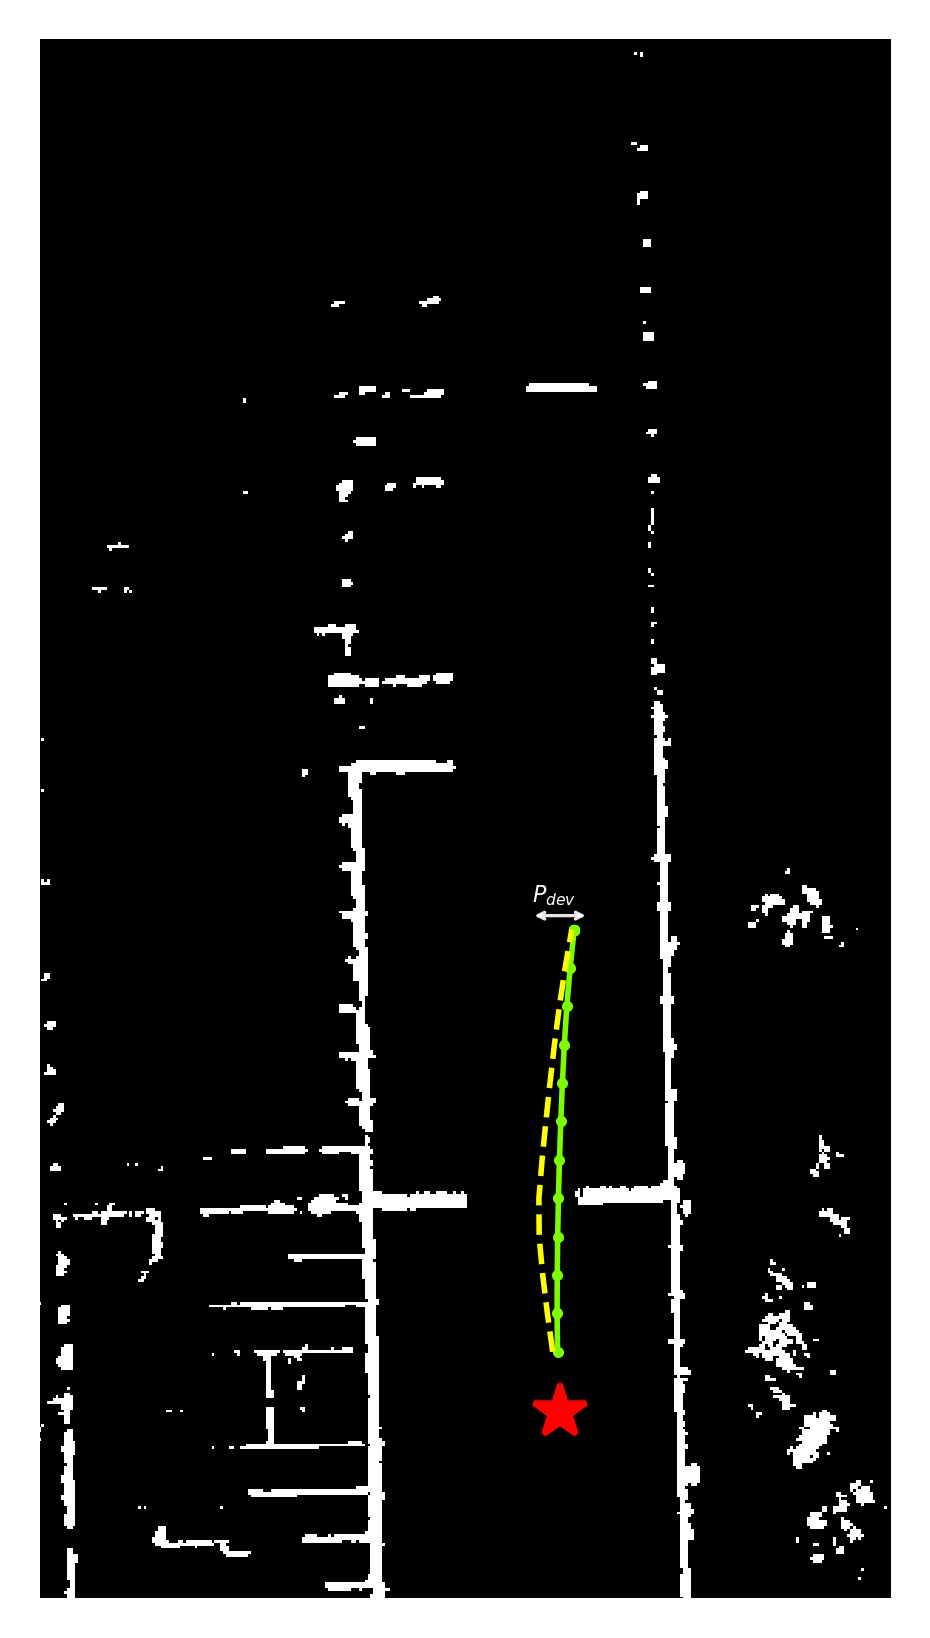

In [7]:
normalized_factor=1536
idx=48#107
plt.figure(figsize=(3,5),dpi=400)
plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='gray')

#plt.colorbar()
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "-o",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)

"""plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)
"""
plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "*",
    color="red",
    markersize=10,
)
#plt.legend(['gt_init_path', 'gt_opt_path', 'car_centre'], loc='lower left')
#plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left',fontsize=2)
plt.tight_layout()
#plt.title(f"Test Index: {idx}",fontsize=3)
plt.axis("off")
plt.ylim(500,1050)
plt.xlim(600,900)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)


file_name = file_details[idx].numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")


arrowprops = dict(arrowstyle="<->,head_length=0.4,head_width=0.2",lw=0.6, alpha=0.9, color='w')
#bbox=dict(boxstyle="round", alpha=0.7, color='k')

ann_x=init_path[idx][24, 0]*normalized_factor
ann_y=init_path[idx][24, 1]*normalized_factor
plt.annotate(s="$P_{dev}$",xy=(ann_x-15,ann_y+10),size=4, color = 'w',rotation=0)
plt.annotate(s="",xy=(ann_x-18,ann_y+5),xytext=(ann_x+8,ann_y+5),size=3, color = 'w',rotation=90,
                arrowprops=arrowprops)

## Checking distance cost, and direction cost and feature vector


In [21]:
init_path[idx][0]

array([0.52792019, 0.61546564])

Text(0.5, 1.0, 'Direction cost')

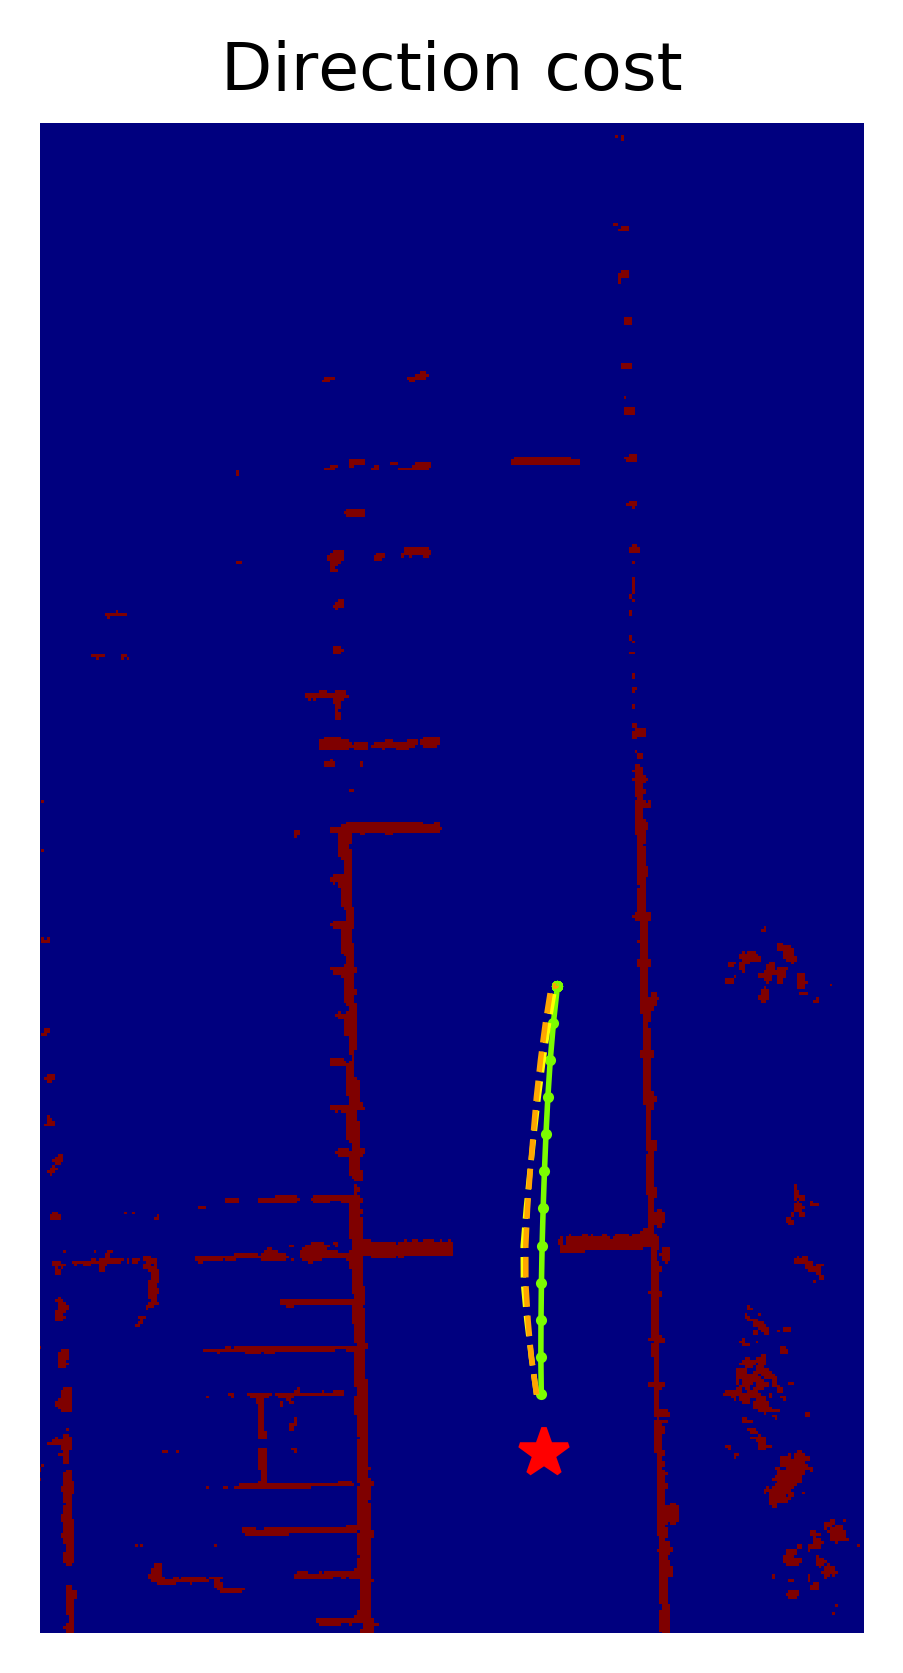

In [8]:
def calc_direction_cost(car_coords:ndarray,endpoint_unit_normal:ndarray,vector:ndarray):
    direction = car_coords-vector
    direction_unit = direction/np.linalg.norm(x=direction)

    direction_cost = np.dot(direction_unit,endpoint_unit_normal)

    return direction_cost

def calc_costmap(gridmap:ndarray,car_odo:ndarray,initial_path:ndarray,include_dir_cost:bool=True,distance_mag:float=0.23)->ndarray:
    """Function to transfor grid map to cost map

    Args:
        gridmap (ndarray): Binary occupancy grid map
        car_odo (ndarray): [description]
        initial_path (ndarray): [description]
        distance_mag (float, optional): lower it is larger cost considered for the occupied cells. Defaults to 0.40.

    Returns:
        ndarray: [description]
    """
    
    car_coords = car_odo[0:2]
    end_coords = initial_path[-1]
    
    # Normalize coordinates to 0-1536 range
    #car_coords = (car_coords-gd_org_res[0:2])/gd_org_res[2]
    #end_coords = (end_coords-gd_org_res[0:2])/gd_org_res[2]

    # Initialize distance and direction costmap 
    dist_costmap = np.zeros(shape=(1536,1536))
    dir_costmap =  np.zeros(shape=(1536,1536))

    ################# calculate distance costmap ################
    
    # get occuppied cell indices
    (y,x) = np.where(gridmap==np.max(gridmap))
    # create coordinate pairs of location of occupied cells
    coords = np.array((x,y)).T

    # eucledian difference
    distance = np.square(coords-car_coords)
    distance = np.sum(distance, axis=1)
    distance = 1/(distance**distance_mag)
    dist_costmap[(y,x)]=distance

    ################# Direction cost map ######################
    
    if include_dir_cost:

        # end point direction
        direction_vector = car_coords-end_coords

        # unit vector between, car location and end point
        end_dir_unit = direction_vector/np.linalg.norm(x=direction_vector)

        # calculate dir cost for all occupied cell locations
        direction_cost= np.asarray([calc_direction_cost(car_coords=car_coords,endpoint_unit_normal=end_dir_unit,vector=coord) for coord in coords])

        # zero down all opposite directions to end point
        direction_cost[np.where(direction_cost<0)]=0.0

        dir_costmap[(y,x)] = direction_cost
    else:
        dir_costmap = np.ones(shape=(1536,1536))

    # pointwise multiply distance cost and direction cost
    costmap = dist_costmap*dir_costmap

    # normalize cost map between [0,1]
    costmap = costmap/np.max(costmap)
    #cp=r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\npzcostmaps'
    #np.savez_compressed(os.path.join(cp,file_details.decode("utf-8").split('/')[-1]),grid_data=costmap.astype(np.float16))
    return costmap.astype(float)

"""final_total_cost_map = np.zeros_like(cost_map[idx])
for pnt in range(20):
    total_cost_map = calc_costmap(gridmap=cost_map[idx].astype(float),
                                    car_odo=init_path[idx][pnt]*normalized_factor,initial_path=init_path[idx]*normalized_factor,
                                    #car_odo=car_odo[idx]*normalized_factor,initial_path=init_path[idx]*normalized_factor,
                                    include_dir_cost=True)
    final_total_cost_map+=total_cost_map"""

total_cost_map = calc_costmap(gridmap=cost_map[idx].astype(float),
                                #car_odo=init_path[idx][pnt]*normalized_factor,initial_path=init_path[idx]*normalized_factor,
                                car_odo=car_odo[idx]*normalized_factor,initial_path=init_path[idx]*normalized_factor,
                                include_dir_cost=True)
total_cost_map = cost_map[idx]
plt.figure(figsize=(3,5),dpi=400)
plt.imshow((total_cost_map).astype(float),origin='lower',cmap='jet')

#plt.colorbar(fraction=0.05)
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)


plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)

plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "*",
    color="red",
    markersize=9,
)
plt.axis("off")
plt.ylim(500,1050)
plt.xlim(600,900)
#plt.legend(['gt_init_path', 'gt_opt_path', 'car_centre'], loc='lower left')
#plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')

plt.title("Direction cost")

### Feature vector illustration

Text(773.4791564941406, 770.7411651611328, '$\\}$')

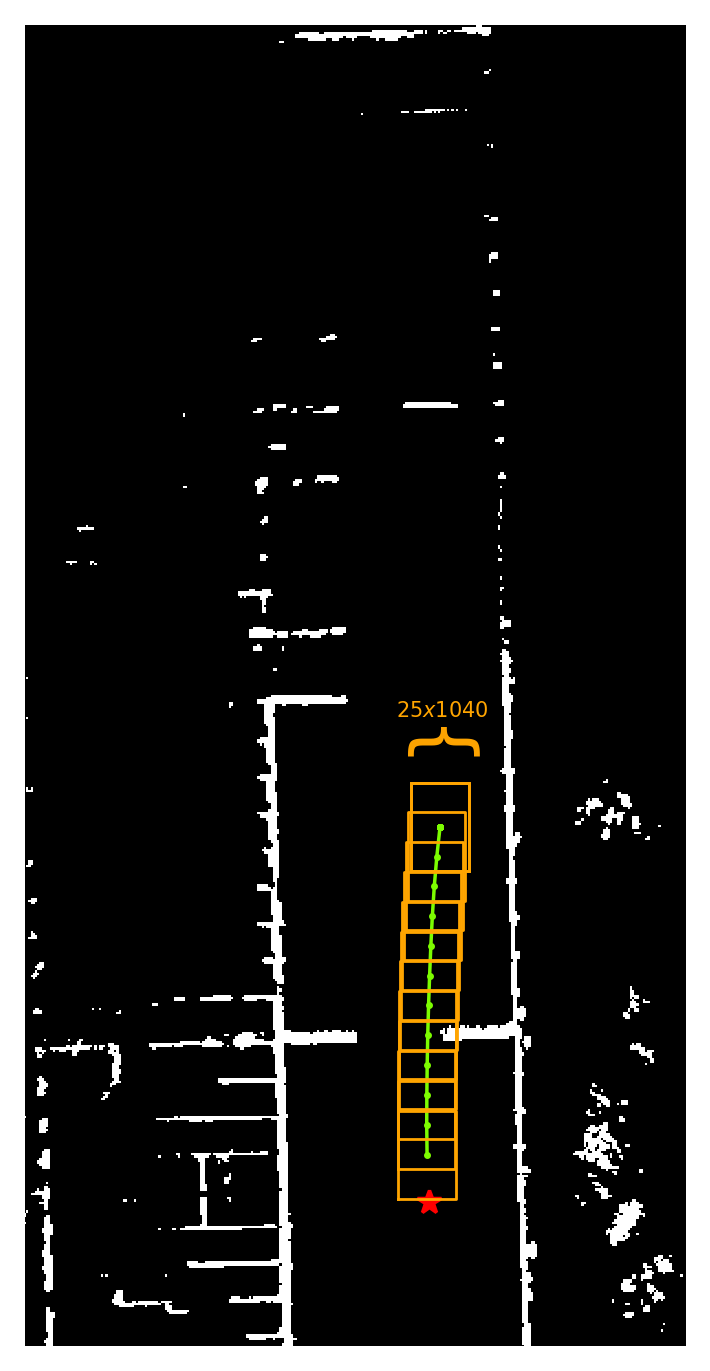

In [9]:
plt.figure(figsize=(5,7),dpi=250)
plt.imshow(total_cost_map.astype(float),origin='lower',cmap='gray')

#plt.colorbar(fraction=0.05)
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
'''plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)'''


"""plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)"""

plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "*",
    color="red",
    markersize=7,
)
#plt.legend(['gt_init_path', 'gt_opt_path', 'car_centre'], loc='lower left')
#plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')
plt.axis("off")
plt.ylim(500,1100)
plt.xlim(600,900)


xoff = 13
yoff = 20

point_idx = 3
for point_idx in range(25):
    pth_x = init_path[idx][point_idx,0]*normalized_factor
    pth_y = init_path[idx][point_idx,1]*normalized_factor
    box_x = [pth_x-xoff, pth_x-xoff, pth_x+xoff, pth_x+xoff, pth_x-xoff]
    box_y = [pth_y-yoff, pth_y+yoff, pth_y+yoff, pth_y-yoff, pth_y-yoff] 
    plt.plot(box_x,box_y,color='orange',linewidth=0.8)

plt.annotate(r"$25 x 1040$",fontsize=6,
            xy=(pth_x-50, pth_y-50), 
            xytext=(pth_x-20, pth_y+50),
            rotation=0, color='orange'
            #xycoords='figure fraction'
            )
plt.annotate(r"$\}$",fontsize=22,
            xy=(pth_x-50, pth_y-50), 
            xytext=(pth_x-15, pth_y+35),
            rotation=90, color='orange'
            #xycoords='figure fraction'
            )

#### Feature for single way point

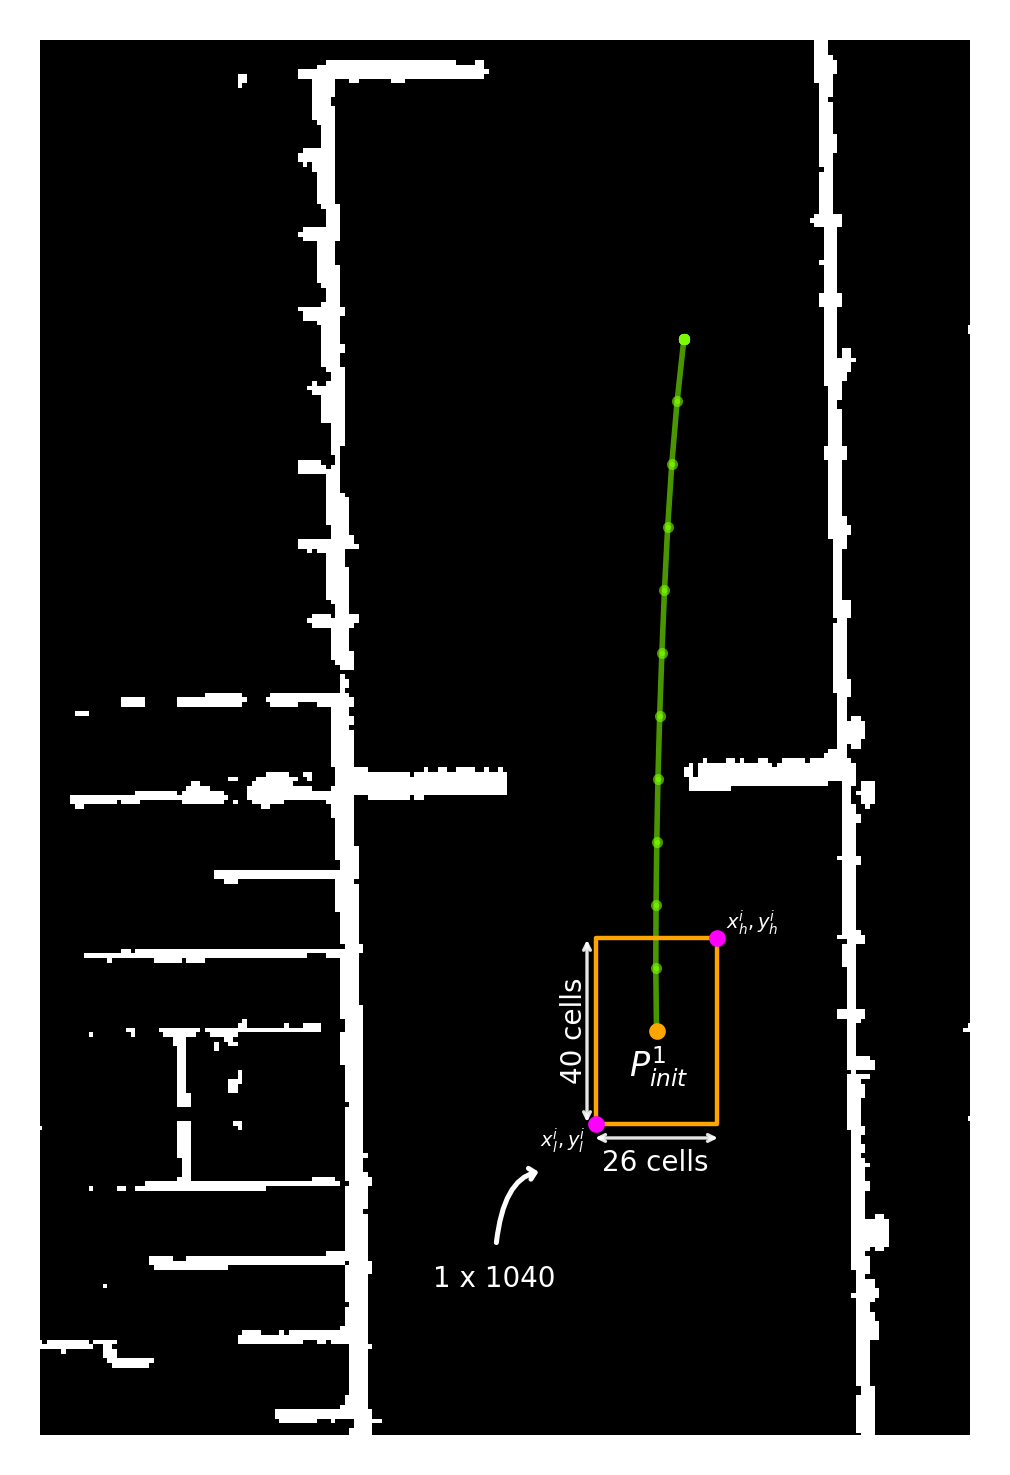

In [29]:
plt.figure(figsize=(3,5),dpi=400)
plt.imshow(total_cost_map.astype(float),origin='lower',cmap='gray')

#plt.colorbar(fraction=0.05)
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,alpha=0.6
)
'''plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)'''


"""plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)"""

"""plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "*",
    color="red",
    markersize=3,
)"""
#plt.legend(['gt_init_path', 'gt_opt_path', 'car_centre'], loc='lower left')
#plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')
plt.axis("off")
plt.ylim(500,800)
plt.xlim(650,850)


xoff = 13
yoff = 20

#point_idx = 3
for point_idx in range(1):
    pth_x = init_path[idx][point_idx,0]*normalized_factor
    pth_y = init_path[idx][point_idx,1]*normalized_factor
    box_x = [pth_x-xoff, pth_x-xoff, pth_x+xoff, pth_x+xoff, pth_x-xoff]
    box_y = [pth_y-yoff, pth_y+yoff, pth_y+yoff, pth_y-yoff, pth_y-yoff] 
    plt.plot(box_x,box_y,color='orange',linewidth=0.8)

    # arrow and box for annotations
    plt.plot(pth_x,pth_y,"o-",color="orange",
            markersize=2,linewidth=1)
    plt.annotate(s="$P^{{1}}_{{init}}$",xy=(pth_x,pth_y),xytext=(pth_x-6,pth_y-10),size=6, color = 'w',)
    arrowprops = dict(arrowstyle="<->,head_length=0.4,head_width=0.2",lw=0.6, alpha=0.9, color='w')

    #lowerleft
    plt.plot(box_x[0],box_y[0],"o-",color="magenta",
            markersize=2,linewidth=1)
    plt.annotate(s="$x_l^{i},y_l^{i}$",xy=(box_x[0],box_y[0]),xytext=(box_x[0]-12,box_y[0]-5),size=3.5, color = 'w')

    #upperright
    plt.plot(box_x[2],box_y[2],"o-",color="magenta",
            markersize=2,linewidth=1)
    plt.annotate(s="$x_h^{i},y_h^{i}$",xy=(box_x[2],box_y[2]),xytext=(box_x[2]+2,box_y[2]+2),size=3.5, color = 'w')


    #bbox=dict(boxstyle="round", alpha=0.7, color='k')
    plt.annotate(s="40 cells",xy=(pth_x-1.6*xoff,pth_y-yoff/2),size=5, color = 'w',rotation=90)
    plt.annotate(s="",xy=(pth_x-1.15*xoff,pth_y-1.1*yoff),xytext=(pth_x-1.15*xoff,pth_y+1.1*yoff),size=3, color = 'w',rotation=90,
                    arrowprops=arrowprops)
    #plt.arrow(x=pth_x-1.15*xoff,y=pth_y-yoff,dx=0,dy=40,color='w')

    plt.annotate(s="26 cells",xy=(pth_x-xoff/1.1,pth_y-1.5*yoff),size=5, color = 'w',rotation=0)
    plt.annotate(s="",xy=(pth_x-1.2*xoff,pth_y-1.15*yoff),xytext=(pth_x+1.2*xoff,pth_y-1.15*yoff),size=3, color = 'w',rotation=0,
                    arrowprops=arrowprops)


    # annotation arrow
    arrowprops = dict(arrowstyle="->,head_length=0.2,head_width=0.2",lw=0.9, connectionstyle="angle3,angleA=90,angleB=0",color='w')
    plt.annotate('1 x 1040', 
                xy=(pth_x-xoff-10,pth_y-yoff-10), 
                xytext=(pth_x-xoff-35,pth_y-yoff-35), color='w',
                arrowprops=arrowprops,
                size = 5)

## Metrics and evaluation
 * DTW (Dynamic time warp)
 * ADE (Average Displacement error)


In [176]:
from pydtw import dtw2d
from tqdm import tqdm
from datetime import datetime

def calc_dtw(optimized_path_gt:ndarray, predicted_paths_m:ndarray)->List:
    all_cost = []
    for index in trange(optimized_path_gt.shape[0]):
        cost_matrix, cost, _,_ = dtw2d(optimized_path_gt[index],predicted_paths_m[index])
        all_cost.append(cost)
    return all_cost

def ADE(optimized_path_gt:ndarray, predicted_paths_m:ndarray):
    # batchsize,25,2
    dist = np.mean(np.sqrt(np.sum((optimized_path_gt - predicted_paths_m)**2,axis=2)),axis=1)
    #np.linalg.norm(optimized_path_gt - predicted_paths_m)
    print(sum(dist)/len(dist))
    return sum(dist)/len(dist)

def eval_models(model_paths:List[str],opt_paths,save_results:bool=False):

    for i,m_path in tqdm(enumerate(model_paths)):

        load_wandb  = tf.keras.models.load_model(m_path)
        predictions = load_wandb.predict(feature_v)
        predicted_paths = init_path - predictions

        scaled_opt_paths = opt_paths*1536
        scaled_predicted_paths = predicted_paths*1536

        dtw = calc_dtw(optimized_path_gt=scaled_opt_paths,predicted_paths_m=scaled_predicted_paths)
        avg_de = ADE(optimized_path_gt=scaled_opt_paths,predicted_paths_m=scaled_predicted_paths)

        print(f"\n Model: {m_path.split('/')[-3]}, DTW: {sum(dtw):.3f}, avg_DTW:{np.mean(dtw):.3f}, ADE: {avg_de}")

        if save_results:
            file_path = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/metrics_results'
            file_path = os.path.join(file_path,'all_results.txt')
            with open(file_path, 'a') as f:
                if i==0:
                    f.write(f"INFO: {datetime.now()}\n")
                f.write(f"Model: {m_path.split('/')[-3]}, DTW: {sum(dtw):.3f}, avg_DTW:{np.mean(dtw):.3f}, ADE: {avg_de:.3f} \n")
                f.close()

eval_models(model_paths=all_model_paths,opt_paths=opt_path,save_results=False)


100%|██████████| 144/144 [00:00<00:00, 15325.94it/s]
1it [00:00,  1.12it/s]

0.8863525772036971

 Model: run-20211007_142205-4f16v6pz, DTW: 38000.478, avg_DTW:263.892, ADE: 0.8863525772036971


## Save all plots from test set

In [8]:
wandbmodel_path.split("/")[-3]

'run-20210924_031631-lhsjbn8r'

In [11]:
for wandbmodel_path in tqdm(all_model_paths):
    load_wandb  = tf.keras.models.load_model(wandbmodel_path)
    predictions = load_wandb.predict(feature_v)
    predicted_paths = init_path - predictions


    SAVE_ALL = False

    if SAVE_ALL:
        model_name = wandbmodel_path.split("/")[-3]#'bgm_LSTM_2_50'#wandbmodel_path.split("/")[-3]
        #'TDD_64_first'#wandbmodel_path.split("/")[-3]#'TDD_4_2'
        save_dir_root = '/projects/malyala/New_folder/rosbag2numpy/test_results/feature_vec_res/crop/binary'
        #'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/feature_vec_res/crop/binary'

        #%matplotlib agg
        #idx= 23#35#23#54#50#25#122#82#42#48
        normalized_factor=1536

        for idx in trange(predicted_paths.shape[0]):

            #plt.figure(figsize=(15,15),dpi=400)
            plt.figure(figsize=(3,5),dpi=500)

            plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='gray')
            #plt.colorbar()
            plt.plot(
                init_path[idx][:, 0]*normalized_factor,
                init_path[idx][:, 1]*normalized_factor,
                "o-",
                color="lawngreen",
                markersize=1.5,
                linewidth=1,
            )
            plt.plot(
                opt_path[idx][:, 0]*normalized_factor,
                opt_path[idx][:, 1]*normalized_factor,
                "--",
                color="yellow",
                markersize=1,
                linewidth=1,
            )
            plt.plot(
                predicted_paths[idx][:, 0]*normalized_factor,
                predicted_paths[idx][:, 1]*normalized_factor,
                "--",
                color="orange",
                markersize=1,
                linewidth=1,
            )
            plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
                "r*",
                color="red",
                markersize=10,
            )

            plt.tight_layout()
            #plt.title(f"Test Index: {idx}",fontsize=3)
            plt.axis("off")
            plt.ylim(500,1050)
            plt.xlim(600,900)
            plt.xticks(fontsize=4)
            plt.yticks(fontsize=4)
            
            #plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')

            file_name = file_details[idx].numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")
            #plt.title(f"{file_name}\nTest Index: {idx}")

            split_details = os.path.split(file_name)[0]
            scene_name = os.path.split(split_details)[0]
            
            # directory to save 
            save_dir = os.path.join(save_dir_root,model_name,scene_name)

            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(f"{save_dir}/Test_index_{idx}.png",dpi=500,figsize=(3,5),bbox_inches='tight')
            plt.close()

    

100%|██████████| 9/9 [15:55<00:00, 106.22s/it]


## Iteration robustness check

In [ ]:
def get_feature_vector_old(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    # np.array(init_path.shape[0],4*offset[0]*offset[1])
    for i in range(init_path.shape[0]):
        x_l,y_l = (init_path[i].astype(int)) - offset
        x_h,y_h = (init_path[i].astype(int)) + offset
        cell = 0
        #print("lower:",(x_l,y_l))
        #print("higher:",(x_h,y_h))

        for x in range(x_l,x_h):
            for y in range(y_l,y_h):
                #print(x,y)
                #if cell<feature_vector.shape[1]:
                    #gridmap[row][column]
                feature_vector[i][cell] = gridmap[y][x]
                cell+=1
    return feature_vector

# optimized version (matrix extraction)
def get_feature_vector(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    for i in range(init_path.shape[0]):
        x_l,y_l = (init_path[i].astype(int)) - offset
        x_h,y_h = (init_path[i].astype(int)) + offset
        
        # boundary box snip from costmap
        feature_vector[i] = gridmap[y_l:y_h,x_l:x_h].flatten()
        
    return feature_vector


idx=48#48
sample_init = np_test_ds_all["init_path"][idx]
sample_opt = np_test_ds_all["opt_path"][idx]
sample_gm = np_test_ds_all["cost_map"][idx]
sample_odo = np_test_ds_all["car_odo"][idx]
sample_fv = np_test_ds_all["feature_vector"][idx]
sample_gt_diff = np_test_ds_all["diff_path"][idx]
sample_file_details = np_test_ds_all["file_details"][idx]

def iter_plot_sample(save,cost_map:ndarray,init_path:ndarray,opt_path:ndarray,predicted_path:ndarray,car_odo:ndarray,file_details,itn,idx):
    norm_fac = 1536
    plt.figure(figsize=(3,5),dpi=500)
    
    plt.imshow(cost_map.astype(float),origin='lower',cmap='gray')
    #plt.colorbar()
   
    plt.plot(
        init_path[:, 0]*norm_fac,
        init_path[:, 1]*norm_fac,
        "o-",
        color="lawngreen",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        opt_path[:, 0]*norm_fac,
        opt_path[:, 1]*norm_fac,
        "--",
        color="yellow",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        predicted_path[:, 0]*norm_fac,
        predicted_path[:, 1]*norm_fac,
        "--",
        color="orange",
        markersize=1,
        linewidth=1,
    )
    plt.plot(car_odo[0] *norm_fac,car_odo[1] *norm_fac,
        "r*",
        color="red",
        markersize=8,
    )

    file_name = file_details.numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")
    #plt.title(f"{file_name}\nTest_sample:{idx}\nTest iteration: {itn}")
    plt.title(f"Test iteration: {itn}",fontsize=4)

    plt.tight_layout()
    #plt.title(f"Test Index: {idx}",fontsize=3)
    plt.axis("off")
    plt.ylim(500,1050)
    plt.xlim(600,900)
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)

    #plt.legend(['gt_init_path', 'gt_opt_path', 'predicted_path','car_centre'], loc='lower left')
    
    split_details = os.path.split(file_name)[0]
    scene_name = os.path.split(split_details)[0]
    save_dir_root='/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/iter_results'
    model_name = wandbmodel_path.split("/")[-3]
    # directory t save 
    save_dir = os.path.join(save_dir_root,model_name,scene_name)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if save:
        plt.savefig(f"{save_dir}/Test_index_{idx}_iter_{itn}.png",dpi=500,bbox_inches='tight',figsize=(3,5))
        plt.close()
    #plt.show()


save_iter_init=[]
save_iter_pred=[]
for itn in trange(3):
    model_output = load_wandb.predict(np.expand_dims(sample_fv,axis=0))
    pred_path = (sample_init -model_output)[0]

    save_iter_init.append(sample_init)
    save_iter_pred.append(pred_path)
    iter_plot_sample(save=False,cost_map=sample_gm,init_path=sample_init,opt_path=sample_opt, predicted_path=pred_path, car_odo=sample_odo, file_details = sample_file_details,itn=itn,idx=idx)

    sample_init = pred_path
    sample_fv = get_feature_vector(gridmap=sample_gm,init_path=sample_init*1536,offset=[13,20])



import scipy.io
iter_data_np ={
    'init_iter' : np.asarray(save_iter_init),
    'pred_iter' : np.asarray(save_iter_pred),
}
#Saving to mat file
mat_root_path = '/projects/malyala/New_folder/rosbag2numpy/test_results/iter_results/matfiles'
filename = os.path.join(mat_root_path,f'{idx}_{wandbmodel_path.split(os.path.sep)[-3]}.mat')
#os.makedirs('/projects/malyala/New_folder/rosbag2numpy/test_results/iter_results/matfiles')
#f'{wandbmodel_path.split("_")[-1].split(".")[0]}.mat'
print(filename)
print(np.shape(np.asarray(save_iter_pred)))
scipy.io.savemat(file_name=filename,mdict=iter_data_np)

## Line profile of feature vector function

In [141]:
%load_ext line_profiler

#%lprun -f get_feature_vector_new get_feature_vector_new(gridmap=sample_gm,init_path=sample_init*1536,offset=[13,20])


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 0.001845 s
File: <ipython-input-21-c68dd37fe6a3>
Function: get_feature_vector_new at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           def get_feature_vector_new(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    21         1         49.0     49.0      2.7      feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    22        26         32.0      1.2      1.7      for i in range(init_path.shape[0]):
    23        25        248.0      9.9     13.4          x_l,y_l = (init_path[i].astype(int)) - offset
    24        25        247.0      9.9     13.4          x_h,y_h = (init_path[i].astype(int)) + offset
    25                                                   
    26                                                   # boundary box snip from costmap
    27        25       1268.0     50.7     68.7          feature_vector[i] = gridmap[y_l:y_h,x_l:x_h].flatten(